# Dimensionality Reduction Evaluation
C. Heiser, 2019

---
__The purpose of this notebook is to evaluate dimensionality reduction techniques for their ability to preserve Euclidean structure of high-dimensional datasets.__  
  
To benchmark these techniques, we are using two single-cell RNAseq datasets:
* From [__Macosko, *et al* (2015)__](https://www.ncbi.nlm.nih.gov/pubmed/26000488), the mouse retina scRNA-seq data generated using DropSeq: [GSM1626793](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM1626793)
* From [__Herring, *et al* (2018)__](https://www.ncbi.nlm.nih.gov/pubmed/29153838), the WT mouse colon scRNA-seq data generated using inDrops: [GSM2743164](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM2743164)  
  
The first set should be __discrete__, containing highly separable cell populations from the mouse retina, where the latter will be __continuous__, representing a continuum of branching cell states in the gut epithelium.  
  
Both datasets have been __preprocessed and feature-selected__ to allow for direct input to downstream dimensionality reduction algorithms (rather than first performing PCA to limit dimensional input). These methods are shown in [`dev/QC.ipynb`](dev/QC.ipynb).

In [1]:
import sys
sys.path.append('../../../DR-structure-preservation/')
from fcc_utils import *
%matplotlib inline

In [66]:
# reload functions when editing file
del sys.modules['fcc_utils']
from fcc_utils import *

In [2]:
# read in Macosko retina data
retina = sc.read_text('../../inputs/GSM1626793_P14Retina_1.processed.tsv', delimiter='\t')
# read in Herring colon data
colon = sc.read_text('../../inputs/GSM2743164_rep1_colon_rnaseq.processed.tsv', delimiter='\t', first_column_names=True)

In [3]:
# look at dimensions of counts matrix (cells, genes)
retina

AnnData object with n_obs × n_vars = 1326 × 500 

In [4]:
# get useful metrics of counts data
retina.var['mito'] = retina.var_names.str.contains('MT:')
sc.pp.calculate_qc_metrics(retina, qc_vars=['mito'], inplace=True)

# preprocess AnnData for downstream dimensionality reduction
retina.layers['raw_counts'] = retina.X.copy() # save raw counts in layer
sc.pp.normalize_total(retina, target_sum=1, layers=None, key_added='norm_factor') # normalize within each cell to get fractional counts
arcsinh(retina, scale=1000) # arcsinh-transform normalized counts and add to .layers['arcsinh_norm']

# see resulting AnnData contents
retina

AnnData object with n_obs × n_vars = 1326 × 500 
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'norm_factor'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'raw_counts', 'arcsinh_norm'

In [5]:
# look at dimensions of counts matrix (cells, genes)
colon

AnnData object with n_obs × n_vars = 1117 × 500 

In [6]:
# get useful metrics of counts data
colon.var['mito'] = colon.var_names.str.contains('mt-')
sc.pp.calculate_qc_metrics(colon, qc_vars=['mito'], inplace=True)

# preprocess AnnData for downstream dimensionality reduction
colon.layers['raw_counts'] = colon.X.copy() # save raw counts in layer
sc.pp.normalize_total(colon, target_sum=1, layers=None, key_added='norm_factor') # normalize within each cell to get fractional counts
arcsinh(colon, scale=1000) # arcsinh-transform normalized counts and add to .layers['arcsinh_norm']

# see resulting AnnData contents
colon

AnnData object with n_obs × n_vars = 1117 × 500 
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'norm_factor'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'raw_counts', 'arcsinh_norm'

---
### PCA
We'll look at principal component analysis (PCA) first, as a gold-standard. Because PCA performs a __linear__ transformation on the data, 500 PCs should perfectly preserve the overall dataset structure.

In [7]:
retina.X = retina.layers['arcsinh_norm'].copy()
sc.tl.pca(retina, use_highly_variable=False, n_comps=500)

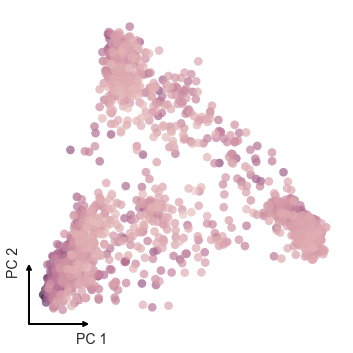

In [8]:
DR_plot(dim_name='PC').plot(retina.obsm['X_pca'], color=retina.obs['log1p_total_counts'])

We can test the Euclidean distance preservation as follows:

In [9]:
# choose value for K-nearest neighbor calculations. We use 30 because that is the standard perplexity chosen for DR techniques here.
k = 30

In [11]:
# save distance matrices in AnnData object for easy access
retina.uns['X_distance'] = cdist(retina.X, retina.X)
retina.uns['PCA500_distance'] = cdist(retina.obsm['X_pca'], retina.obsm['X_pca'])

# calculate simple binary knn graphs for each distance matrix above
knn_graph(retina.uns['X_distance'], k, retina, save_rep='X_knn')
knn_graph(retina.uns['PCA500_distance'], k, retina, save_rep='PCA500_knn')

In [12]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=retina.uns['X_distance'], post=retina.uns['PCA500_distance'])
knn = knn_preservation(pre=retina.uns['X_knn'], post=retina.uns['PCA500_knn'])

Flattening distance matrices into 1D array of unique cell-cell distances...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
CPU times: user 931 ms, sys: 137 ms, total: 1.07 s
Wall time: 655 ms


CPU times: user 265 ms, sys: 36.5 ms, total: 302 ms
Wall time: 116 ms


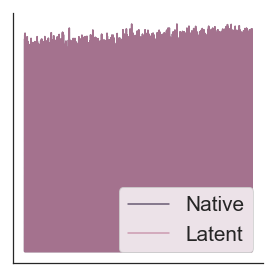

In [43]:
%time SP_plot(pre_flat_norm, post_flat_norm).plot_cell_distances()

CPU times: user 759 ms, sys: 45.6 ms, total: 805 ms
Wall time: 619 ms


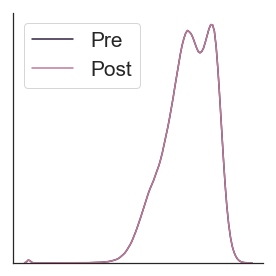

In [44]:
%time SP_plot(pre_flat_norm, post_flat_norm, labels=['Pre','Post']).plot_distributions(legend=True)

CPU times: user 143 ms, sys: 20.4 ms, total: 163 ms
Wall time: 63.8 ms


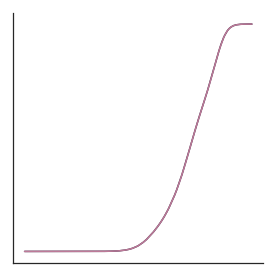

In [45]:
%time SP_plot(pre_flat_norm, post_flat_norm, labels=['Pre','Post']).plot_cumulative_distributions(legend=False)

CPU times: user 892 ms, sys: 38.1 ms, total: 930 ms
Wall time: 746 ms


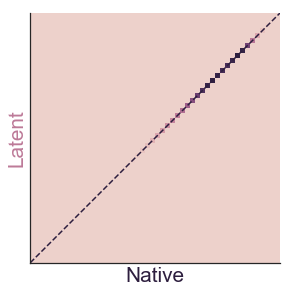

In [46]:
%time SP_plot(pre_flat_norm, post_flat_norm).plot_distance_correlation()

CPU times: user 1.16 s, sys: 71.5 ms, total: 1.23 s
Wall time: 895 ms


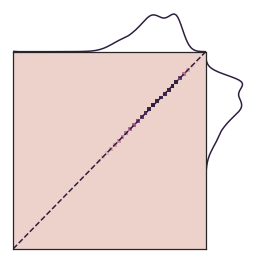

In [62]:
%time SP_plot(pre_flat_norm, post_flat_norm, labels=False).joint_plot_distance_correlation()

CPU times: user 1.16 s, sys: 66.1 ms, total: 1.22 s
Wall time: 900 ms


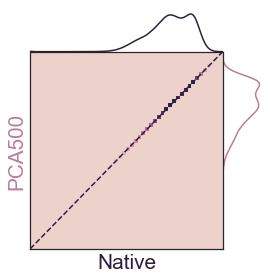

In [67]:
%time SP_plot(pre_flat_norm, post_flat_norm, labels=['Native','PCA500']).joint_plot_distance_correlation()

Now we can perform a PCA with a smaller number of components and determine the degree of information loss.  
The extreme example would be comparing only the __first two principal components__ to the original dataset:

In [68]:
# create dictionaries for dumping results into
final_distance_stats = {'Retina':{'R':{}, 'EMD':{}, 'Knn Pres.':{}}, 'Colon':{'R':{}, 'EMD':{}, 'Knn Pres.':{}}}

In [69]:
retina.obsm['PCA500'] = retina.obsm['X_pca'] # save 500-component PCA in different .obsm slot before overwriting
sc.tl.pca(retina, use_highly_variable=False, n_comps=2) # perform 2-component PCA
retina.obsm['PCA2'] = retina.obsm['X_pca'] # save 2-component PCA in another .obsm slot

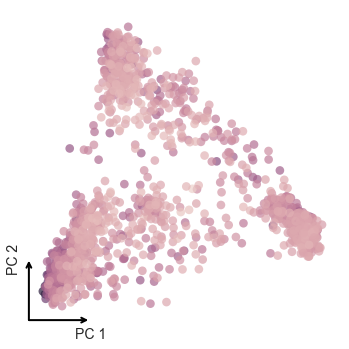

In [48]:
plot_DR(retina.obsm['PCA2'], color=retina.obs['log1p_total_counts'], dim_name='PC')

The first two PCs are the same, so the plot should be identical to before.  
We can check the dimensions of our PCA results to make sure they are as expected:

In [49]:
print('500-component PCA dimensions: {}'.format(retina.obsm['PCA500'].shape))
print('2-component PCA dimensions: {}'.format(retina.obsm['PCA2'].shape))

500-component PCA dimensions: (1326, 500)
2-component PCA dimensions: (1326, 2)


In [50]:
# save distance matrix in AnnData object for easy access
retina.uns['PCA2_distance'] = distance_matrix(retina.obsm['PCA2'], retina.obsm['PCA2'])

# calculate simple binary knn graph the distance matrix above
knn_graph(retina.uns['PCA2_distance'], k, retina, save_rep='PCA2_knn')

In [51]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=retina.uns['X_distance'], post=retina.uns['PCA2_distance'])
knn = knn_preservation(pre=retina.uns['X_knn'], post=retina.uns['PCA2_knn'])
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['PCA (2)'], final_distance_stats['Retina']['EMD']['PCA (2)'], final_distance_stats['Retina']['Knn Pres.']['PCA (2)'] = mantel_stats[0], EMD, knn

R: 0.7718
EMD: 0.2231
Knn Pres.: 96.7996
CPU times: user 2min 7s, sys: 26.6 s, total: 2min 34s
Wall time: 26.6 s


CPU times: user 893 ms, sys: 49.8 ms, total: 943 ms
Wall time: 725 ms


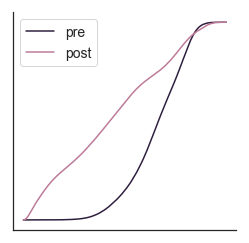

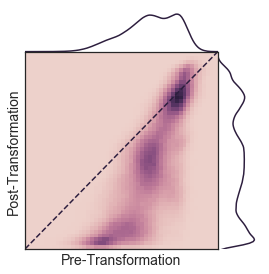

In [52]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
#plt.savefig(fname='../images/retina_PCA2_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
#plt.savefig(fname='../images/retina_PCA2_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

Now perform same analysis on colon dataset

In [70]:
colon.X = colon.layers['arcsinh_norm'] # move arcsinh-normalized values into default slot
sc.tl.pca(colon, use_highly_variable=False, n_comps=2) # perform 2-component PCA
colon.obsm['PCA2'] = colon.obsm['X_pca'] # save 2-component PCA in another .obsm slot

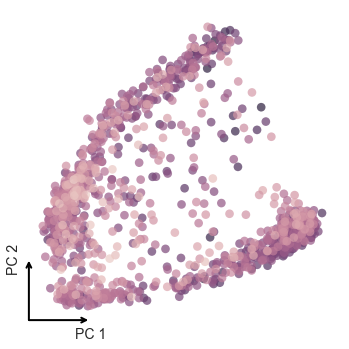

In [54]:
plot_DR(colon.obsm['PCA2'], color=colon.obs['log1p_total_counts'], dim_name='PC')

In [72]:
# save distance matrix in AnnData object for easy access
colon.uns['X_distance'] = cdist(colon.X, colon.X)
colon.uns['PCA2_distance'] = cdist(colon.obsm['PCA2'], colon.obsm['PCA2'])

# calculate simple binary knn graph the distance matrix above
knn_graph(colon.uns['X_distance'], k, colon, save_rep='X_knn')
knn_graph(colon.uns['PCA2_distance'], k, colon, save_rep='PCA2_knn')

In [73]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=colon.uns['X_distance'], post=colon.uns['PCA2_distance'])
knn = knn_preservation(pre=colon.uns['X_knn'], post=colon.uns['PCA2_knn'])
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
#final_distance_stats['Colon']['R']['PCA (2)'], final_distance_stats['Colon']['EMD']['PCA (2)'], final_distance_stats['Colon']['Knn Pres.']['PCA (2)'] = mantel_stats[0], EMD, knn

Flattening distance matrices into 1D array of unique cell-cell distances...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
R: 0.9353
EMD: 0.1685
Knn Pres.: 97.529
CPU times: user 749 ms, sys: 80.6 ms, total: 830 ms
Wall time: 412 ms


CPU times: user 1.08 s, sys: 74.6 ms, total: 1.15 s
Wall time: 726 ms


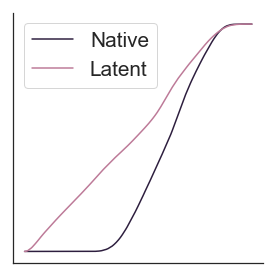

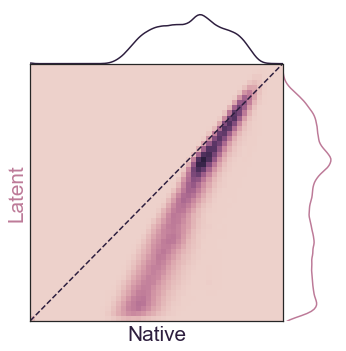

In [76]:
%%time
SP_plot(pre_flat_norm, post_flat_norm).plot_cumulative_distributions()
SP_plot(pre_flat_norm, post_flat_norm, figsize=(5,5)).joint_plot_distance_correlation()

Now let's do __10 PCs__ to compare to __scVI__ output, which is the only DR method we have that can't return a 2D embedding:

In [64]:
sc.tl.pca(retina, use_highly_variable=False, n_comps=10) # perform 10-component PCA
retina.obsm['PCA10'] = retina.obsm['X_pca'] # save 10-component PCA in another .obsm slot

In [65]:
# save distance matrix in AnnData object for easy access
retina.uns['PCA10_distance'] = distance_matrix(retina.obsm['PCA10'], retina.obsm['PCA10'])

# calculate simple binary knn graph the distance matrix above
knn_graph(retina.uns['PCA10_distance'], k, retina, save_rep='PCA10_knn')

In [66]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=retina.uns['X_distance'], post=retina.uns['PCA10_distance'])
knn = knn_preservation(pre=retina.uns['X_knn'], post=retina.uns['PCA10_knn'])
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['PCA (10)'], final_distance_stats['Retina']['EMD']['PCA (10)'], final_distance_stats['Retina']['Knn Pres.']['PCA (10)'] = mantel_stats[0], EMD, knn

R: 0.8557
EMD: 0.1659
Knn Pres.: 97.4033
CPU times: user 2min 13s, sys: 27.7 s, total: 2min 41s
Wall time: 27.7 s


CPU times: user 800 ms, sys: 47 ms, total: 847 ms
Wall time: 632 ms


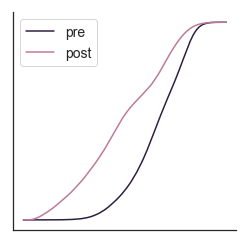

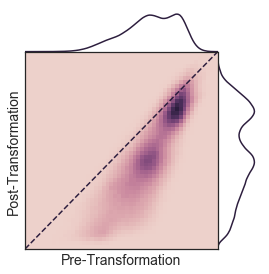

In [67]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
#plt.savefig(fname='../images/retina_PCA2_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
#plt.savefig(fname='../images/retina_PCA2_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

In [68]:
sc.tl.pca(colon, use_highly_variable=False, n_comps=10) # perform 10-component PCA
colon.obsm['PCA10'] = colon.obsm['X_pca'] # save 10-component PCA in another .obsm slot

In [69]:
# save distance matrix in AnnData object for easy access
colon.uns['PCA10_distance'] = distance_matrix(colon.obsm['PCA10'], colon.obsm['PCA10'])

# calculate simple binary knn graph the distance matrix above
knn_graph(colon.uns['PCA10_distance'], k, colon, save_rep='PCA10_knn')

In [70]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=colon.uns['X_distance'], post=colon.uns['PCA10_distance'])
knn = knn_preservation(pre=colon.uns['X_knn'], post=colon.uns['PCA10_knn'])
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['PCA (10)'], final_distance_stats['Colon']['EMD']['PCA (10)'], final_distance_stats['Colon']['Knn Pres.']['PCA (10)'] = mantel_stats[0], EMD, knn

R: 0.9688
EMD: 0.0375
Knn Pres.: 98.0704
CPU times: user 1min 42s, sys: 23.3 s, total: 2min 5s
Wall time: 21.5 s


CPU times: user 642 ms, sys: 46.3 ms, total: 688 ms
Wall time: 472 ms


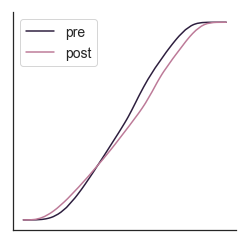

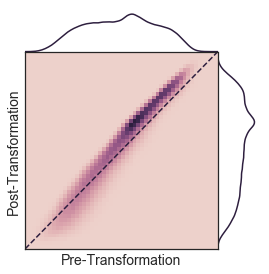

In [71]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
#plt.savefig(fname='../images/retina_PCA2_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
#plt.savefig(fname='../images/retina_PCA2_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
# t-SNE
A workhorse technique for dimensionality reduction and visualization of scRNA-seq datasets, t-SNE performs a stochastic, non-linear transformation to project high-dimensional data into 2D in order to identify clustering and global structure.  
Here, we will plug arcsinh-normalized counts data directly into t-SNE and compare results to the original, feature-selected dataset.

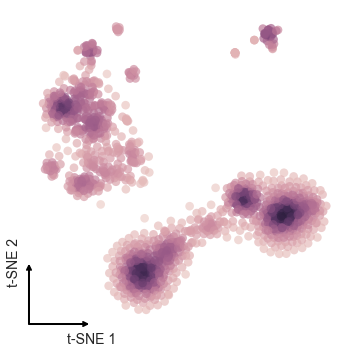

In [34]:
retina_tSNE = DR.from_file('pymethods_out/retina_tSNE.csv', name='t-SNE', labels=[None,None])
retina_tSNE.plot()

In [35]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=retina.distance_matrix(transform='arcsinh'), post=retina_tSNE.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_tSNE.knn_graph(k))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['t-SNE'], final_distance_stats['Retina']['EMD']['t-SNE'], final_distance_stats['Retina']['Knn Pres.']['t-SNE'] = mantel_stats[0], EMD, knn

R: 0.7739
EMD: 0.2165
Knn Pres.: 96.8218
CPU times: user 37.6 s, sys: 7.69 s, total: 45.3 s
Wall time: 45.9 s


CPU times: user 10.7 s, sys: 322 ms, total: 11 s
Wall time: 10.4 s


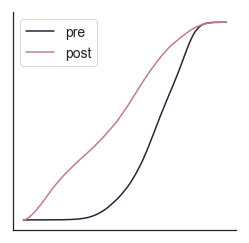

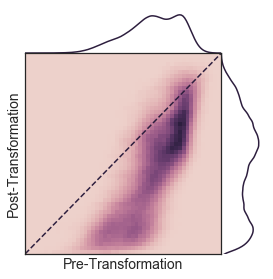

In [36]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_tSNE_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_tSNE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

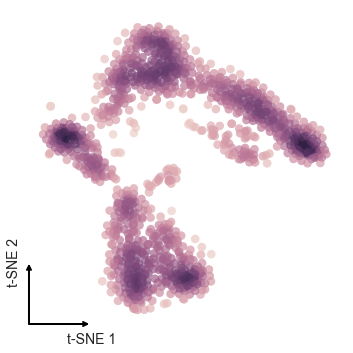

In [37]:
colon_tSNE = DR.from_file('pymethods_out/colon_tSNE.csv', name='t-SNE', labels=[None,None])
colon_tSNE.plot()

In [38]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=colon.distance_matrix(transform='arcsinh'), post=colon_tSNE.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh'), post=colon_tSNE.knn_graph(k))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['t-SNE'], final_distance_stats['Colon']['EMD']['t-SNE'], final_distance_stats['Colon']['Knn Pres.']['t-SNE'] = mantel_stats[0], EMD, knn

R: 0.8816
EMD: 0.0822
Knn Pres.: 97.1733
CPU times: user 24.6 s, sys: 4.84 s, total: 29.4 s
Wall time: 30 s


CPU times: user 10.4 s, sys: 316 ms, total: 10.7 s
Wall time: 10.1 s


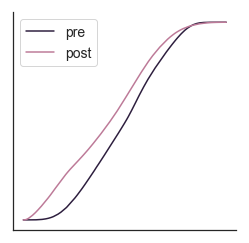

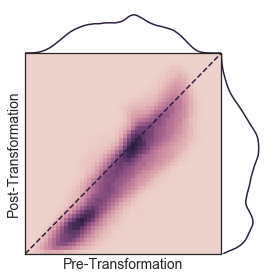

In [39]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_tSNE_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_tSNE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
# FIt-SNE
A workhorse technique for dimensionality reduction and visualization of scRNA-seq datasets, t-SNE performs a stochastic, non-linear transformation to project high-dimensional data into 2D in order to identify clustering and global structure. The FIt-SNE implementation is supposed to be faster and more efficient.  
Here, we will plug arcsinh-normalized counts data directly into t-SNE and compare results to the original, feature-selected dataset.

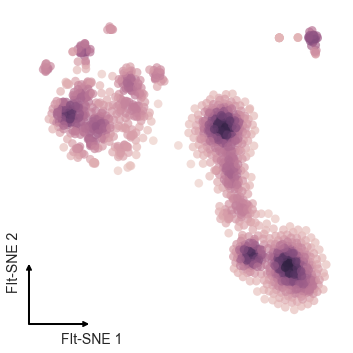

In [40]:
retina_FItSNE = DR.from_file('pymethods_out/retina_FItSNE.csv', name='FIt-SNE', labels=[None,None])
retina_FItSNE.plot()

In [41]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=retina.distance_matrix(transform='arcsinh'), post=retina_FItSNE.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_FItSNE.knn_graph(k))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['FIt-SNE'], final_distance_stats['Retina']['EMD']['FIt-SNE'], final_distance_stats['Retina']['Knn Pres.']['FIt-SNE'] = mantel_stats[0], EMD, knn

R: 0.782
EMD: 0.2708
Knn Pres.: 96.8063
CPU times: user 37.5 s, sys: 7.35 s, total: 44.8 s
Wall time: 45.4 s


CPU times: user 10.9 s, sys: 341 ms, total: 11.2 s
Wall time: 10.9 s


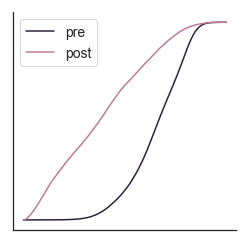

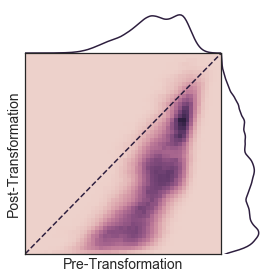

In [42]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_FItSNE_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_FItSNE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

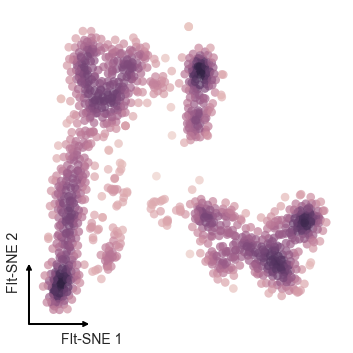

In [43]:
colon_FItSNE = DR.from_file('pymethods_out/colon_FItSNE.csv', name='FIt-SNE', labels=[None,None])
colon_FItSNE.plot()

In [44]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=colon.distance_matrix(transform='arcsinh'), post=colon_FItSNE.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh'), post=colon_FItSNE.knn_graph(k))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['FIt-SNE'], final_distance_stats['Colon']['EMD']['FIt-SNE'], final_distance_stats['Colon']['Knn Pres.']['FIt-SNE'] = mantel_stats[0], EMD, knn

R: 0.8438
EMD: 0.0691
Knn Pres.: 97.148
CPU times: user 24.7 s, sys: 4.87 s, total: 29.6 s
Wall time: 30.1 s


CPU times: user 10.4 s, sys: 312 ms, total: 10.7 s
Wall time: 10.1 s


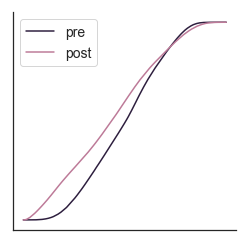

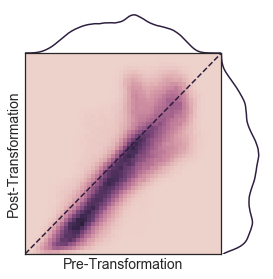

In [45]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_FItSNE_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_FItSNE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
# UMAP
Another popular method for low-dimensional projection of scRNA-seq datasets, UMAP creates high-dimensional manifolds that describe the structure of the dataset.  
Here, we will plug arcsinh-normalized counts data directly into UMAP and compare results to the original, feature-selected dataset.

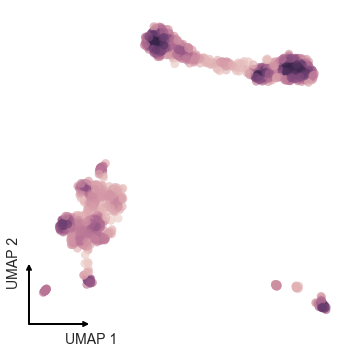

In [46]:
retina_UMAP = DR.from_file('pymethods_out/retina_UMAP.csv', name='UMAP', labels=[None,None])
retina_UMAP.plot()

In [47]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=retina.distance_matrix(transform='arcsinh'), post=retina_UMAP.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_UMAP.knn_graph(k))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['UMAP'], final_distance_stats['Retina']['EMD']['UMAP'], final_distance_stats['Retina']['Knn Pres.']['UMAP'] = mantel_stats[0], EMD, knn

R: 0.7269
EMD: 0.2247
Knn Pres.: 96.6672
CPU times: user 37.9 s, sys: 7.3 s, total: 45.2 s
Wall time: 45.8 s


CPU times: user 10.6 s, sys: 316 ms, total: 10.9 s
Wall time: 10.4 s


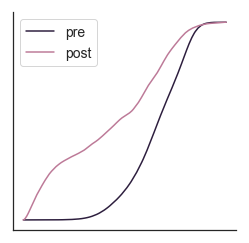

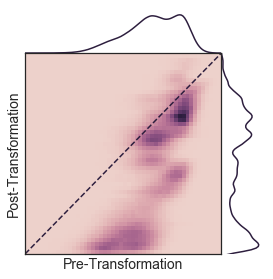

In [48]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_UMAP_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_UMAP_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

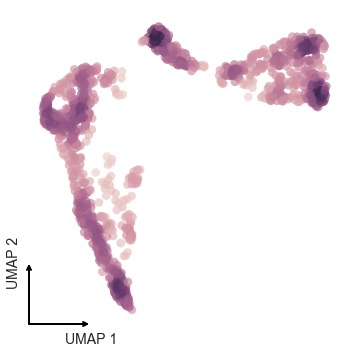

In [49]:
colon_UMAP = DR.from_file('pymethods_out/colon_UMAP.csv', name='UMAP', labels=[None,None])
colon_UMAP.plot()

In [50]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=colon.distance_matrix(transform='arcsinh'), post=colon_UMAP.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh'), post=colon_UMAP.knn_graph(k))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['UMAP'], final_distance_stats['Colon']['EMD']['UMAP'], final_distance_stats['Colon']['Knn Pres.']['UMAP'] = mantel_stats[0], EMD, knn

R: 0.8002
EMD: 0.0936
Knn Pres.: 97.1171
CPU times: user 24.4 s, sys: 4.56 s, total: 29 s
Wall time: 29.4 s


CPU times: user 10.5 s, sys: 326 ms, total: 10.8 s
Wall time: 10.4 s


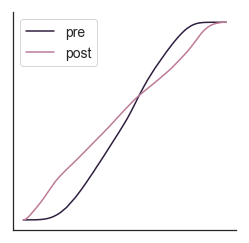

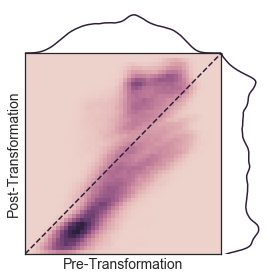

In [51]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_UMAP_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_UMAP_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
# ZIFA
This method uses the zero-inflated negative binomial distribution to reduce RNA counts data to lower dimensions.  
Here, we will plug arcsinh-normalized counts data directly into ZIFA and compare results to the original, feature-selected dataset.

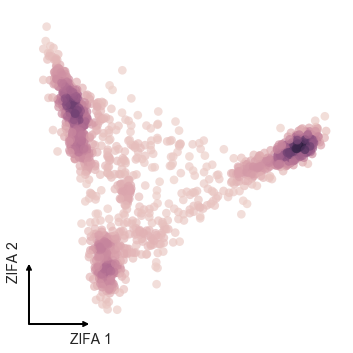

In [52]:
retina_ZIFA = DR.from_file('pymethods_out/retina_ZIFA.csv', name='ZIFA', labels=[None,None])
retina_ZIFA.plot()

In [53]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=retina.distance_matrix(transform='arcsinh'), post=retina_ZIFA.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_ZIFA.knn_graph(k))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['ZIFA'], final_distance_stats['Retina']['EMD']['ZIFA'], final_distance_stats['Retina']['Knn Pres.']['ZIFA'] = mantel_stats[0], EMD, knn

R: 0.6864
EMD: 0.2991
Knn Pres.: 96.5919
CPU times: user 37.5 s, sys: 7.66 s, total: 45.2 s
Wall time: 47.2 s


CPU times: user 10.7 s, sys: 356 ms, total: 11.1 s
Wall time: 10.7 s


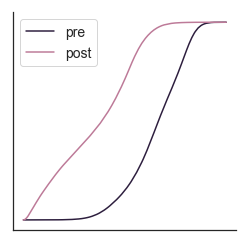

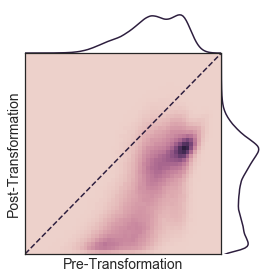

In [54]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_ZIFA_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_ZIFA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

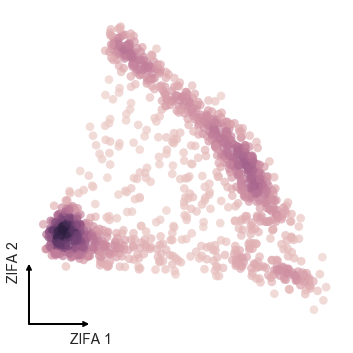

In [55]:
colon_ZIFA = DR.from_file('pymethods_out/colon_ZIFA.csv', name='ZIFA', labels=[None,None])
colon_ZIFA.plot()

In [56]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=colon.distance_matrix(transform='arcsinh'), post=colon_ZIFA.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh'), post=colon_ZIFA.knn_graph(k))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['ZIFA'], final_distance_stats['Colon']['EMD']['ZIFA'], final_distance_stats['Colon']['Knn Pres.']['ZIFA'] = mantel_stats[0], EMD, knn

R: 0.8659
EMD: 0.1364
Knn Pres.: 96.9169
CPU times: user 24.7 s, sys: 4.8 s, total: 29.4 s
Wall time: 29.9 s


CPU times: user 10.4 s, sys: 311 ms, total: 10.7 s
Wall time: 10.1 s


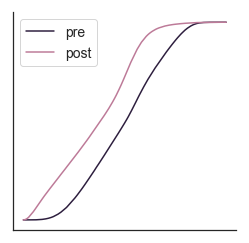

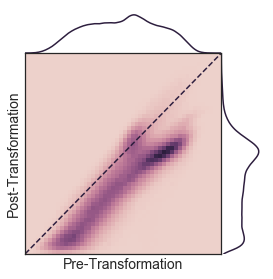

In [57]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_ZIFA_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_ZIFA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
# DCA
This method uses a deep count autoencoder to reduce RNA counts data to lower dimensions.  
Here, we will plug counts data directly into DCA and compare results to the original, feature-selected dataset.

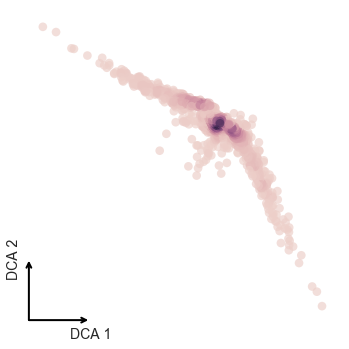

In [133]:
retina_DCA = DR.from_file('pymethods_out/retina_DCA.csv', name='DCA', labels=[None,None])
retina_DCA.plot()

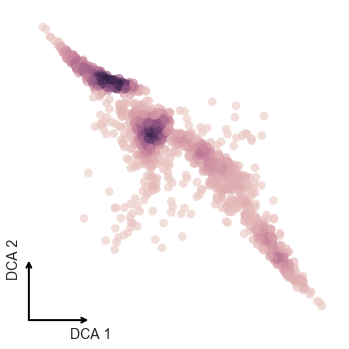

In [134]:
retina_DCA = DR(latent=retina_DCA.arcsinh_norm(norm=None, scale=1), name='DCA')
retina_DCA.plot()

In [118]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=retina.distance_matrix(transform='arcsinh'), post=retina_DCA.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_DCA.knn_graph(k))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['DCA'], final_distance_stats['Retina']['EMD']['DCA'], final_distance_stats['Retina']['Knn Pres.']['DCA'] = mantel_stats[0], EMD, knn

R: 0.4146
EMD: 0.3994
Knn Pres.: 96.7403
CPU times: user 36.5 s, sys: 7.13 s, total: 43.7 s
Wall time: 44 s


CPU times: user 10.8 s, sys: 379 ms, total: 11.2 s
Wall time: 10.7 s


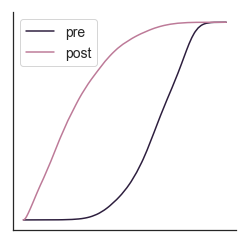

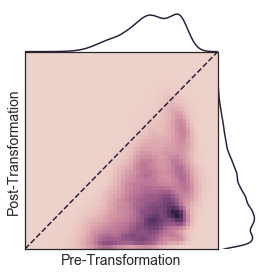

In [119]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_DCA_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_DCA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

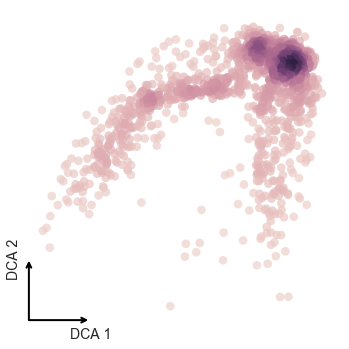

In [135]:
colon_DCA = DR.from_file('pymethods_out/colon_DCA.csv', name='DCA', labels=[None,None])
colon_DCA.plot()

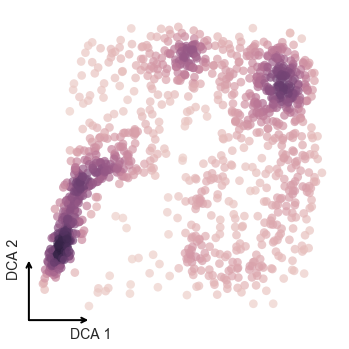

In [136]:
colon_DCA = DR(latent=colon_DCA.arcsinh_norm(norm=None, scale=1), name='DCA')
colon_DCA.plot()

In [137]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=colon.distance_matrix(transform='arcsinh'), post=colon_DCA.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh'), post=colon_DCA.knn_graph(k))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['DCA'], final_distance_stats['Colon']['EMD']['DCA'], final_distance_stats['Colon']['Knn Pres.']['DCA'] = mantel_stats[0], EMD, knn

R: 0.7034
EMD: 0.0991
Knn Pres.: 96.43
CPU times: user 23.7 s, sys: 4.78 s, total: 28.5 s
Wall time: 28.8 s


CPU times: user 10.3 s, sys: 313 ms, total: 10.6 s
Wall time: 9.97 s


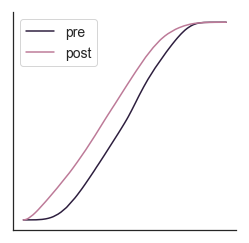

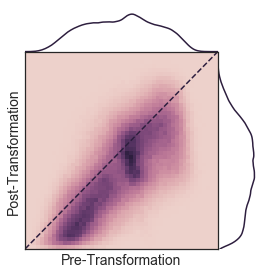

In [138]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_DCA_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_DCA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
# sc-VI
Here, we will plug counts data directly into sc-VI and compare results to the original, feature-selected dataset.

In [64]:
retina_scVI = DR.from_file('pymethods_out/retina_scVI.csv', name='scVI', labels=[None,None])

In [65]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=retina.distance_matrix(transform='arcsinh'), post=retina_scVI.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_scVI.knn_graph(k))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['scVI'], final_distance_stats['Retina']['EMD']['scVI'], final_distance_stats['Retina']['Knn Pres.']['scVI'] = mantel_stats[0], EMD, knn

R: 0.6553
EMD: 0.2052
Knn Pres.: 96.7922
CPU times: user 39.6 s, sys: 7.53 s, total: 47.1 s
Wall time: 47.5 s


CPU times: user 10.4 s, sys: 295 ms, total: 10.7 s
Wall time: 9.98 s


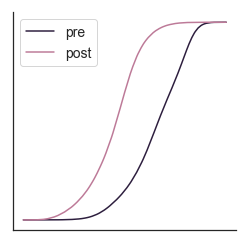

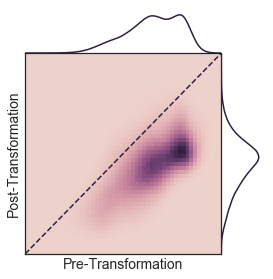

In [66]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_scVI_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_scVI_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

In [67]:
colon_scVI = DR.from_file('pymethods_out/colon_scVI.csv', name='scVI', labels=[None,None])

In [68]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=colon.distance_matrix(transform='arcsinh'), post=colon_scVI.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh'), post=colon_scVI.knn_graph(k))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['scVI'], final_distance_stats['Colon']['EMD']['scVI'], final_distance_stats['Colon']['Knn Pres.']['scVI'] = mantel_stats[0], EMD, knn

R: 0.857
EMD: 0.0725
Knn Pres.: 96.9871
CPU times: user 25.4 s, sys: 4.94 s, total: 30.3 s
Wall time: 30.6 s


CPU times: user 10.2 s, sys: 290 ms, total: 10.5 s
Wall time: 9.81 s


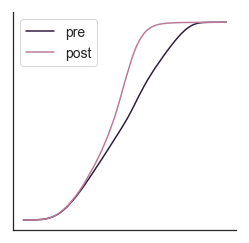

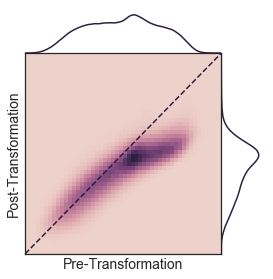

In [69]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_scVI_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_scVI_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
# scvis
Here, we will plug counts data directly into scvis and compare results to the original, feature-selected dataset.

In [139]:
retina_scvis = DR.from_file(datafile='scvis_out/retina/perplexity_30_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.tsv',
                            labels=[0,0], name='scvis')

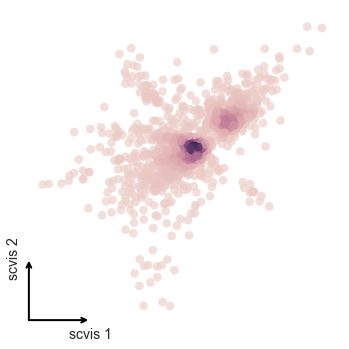

In [140]:
retina_scvis.plot()

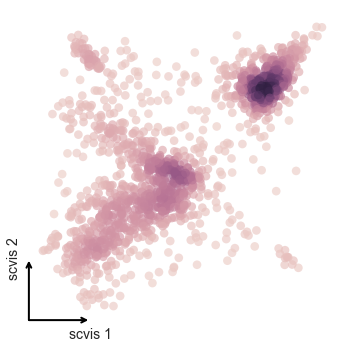

In [141]:
retina_scvis = DR(latent=retina_scvis.arcsinh_norm(norm=None, scale=1), name='scvis')
retina_scvis.plot()

In [142]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=retina.distance_matrix(transform='arcsinh'), post=retina_scvis.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_scvis.knn_graph(k))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['scvis'], final_distance_stats['Retina']['EMD']['scvis'], final_distance_stats['Retina']['Knn Pres.']['scvis'] = mantel_stats[0], EMD, knn

R: 0.5938
EMD: 0.3271
Knn Pres.: 96.7641
CPU times: user 37 s, sys: 7.31 s, total: 44.3 s
Wall time: 44.8 s


CPU times: user 10.3 s, sys: 308 ms, total: 10.7 s
Wall time: 9.97 s


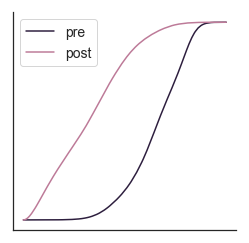

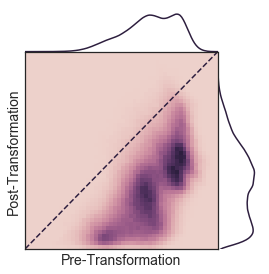

In [143]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_scvis_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_scvis_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

In [144]:
colon_scvis = DR.from_file(datafile='scvis_out/colon/perplexity_30_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.tsv',
                           labels=[0,0], name='scvis')

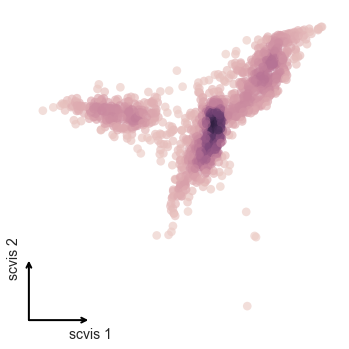

In [145]:
colon_scvis.plot()

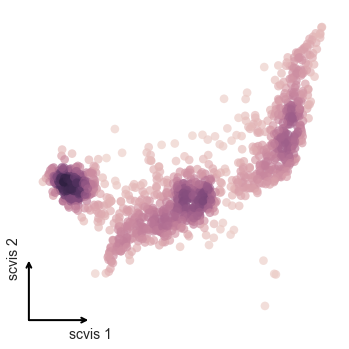

In [146]:
colon_scvis = DR(latent=colon_scvis.arcsinh_norm(norm=None, scale=1), name='scvis')
colon_scvis.plot()

In [147]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=colon.distance_matrix(transform='arcsinh'), post=colon_scvis.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh'), post=colon_scvis.knn_graph(k))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['scvis'], final_distance_stats['Colon']['EMD']['scvis'], final_distance_stats['Colon']['Knn Pres.']['scvis'] = mantel_stats[0], EMD, knn

R: 0.5773
EMD: 0.1563
Knn Pres.: 95.618
CPU times: user 24 s, sys: 4.85 s, total: 28.9 s
Wall time: 29.1 s


CPU times: user 10.2 s, sys: 300 ms, total: 10.5 s
Wall time: 9.86 s


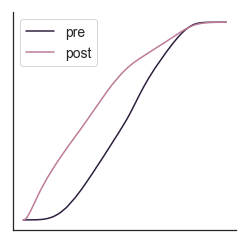

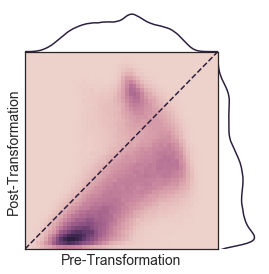

In [148]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_scvis_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_scvis_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
# SIMLR
This method builds cell-cell similarity matrices to predict cluster number and assign cells to clusters based on similarity.
First, read in the `F` construct that consists of a c-dimensional output of length `n_cells`, where c is the number of expected clusters passed to SIMLR.  
Here, c was the number of clusters determined by Seurat Louvain algorithm.

In [151]:
retina_SIMLR = DR.from_file('Rmethods_out/retina_SIMLR_F.csv', name='SIMLR', labels=[None,0]) # read in low-dim space for comparison

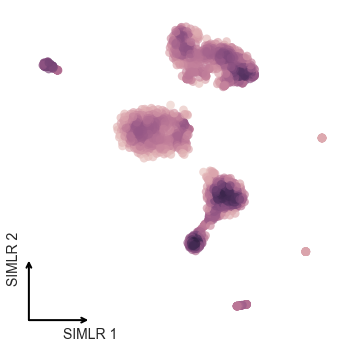

In [152]:
retina_SIMLR.plot()

In [ ]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=retina.distance_matrix(transform='arcsinh'), post=retina_SIMLR.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_SIMLR.knn_graph(k))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['SIMLR'], final_distance_stats['Retina']['EMD']['SIMLR'], final_distance_stats['Retina']['Knn Pres.']['SIMLR'] = mantel_stats[0], EMD, knn

R: 0.526
EMD: 0.3275
Knn Pres.: 97.2329
CPU times: user 37.5 s, sys: 7.59 s, total: 45.1 s
Wall time: 45.5 s


CPU times: user 10.5 s, sys: 314 ms, total: 10.8 s
Wall time: 10.2 s


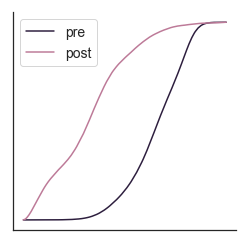

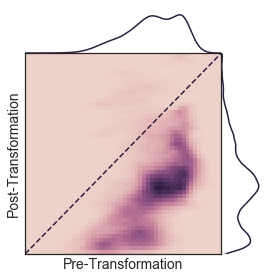

In [ ]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_SIMLR_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_SIMLR_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

In [ ]:
colon_SIMLR = DR.from_file('Rmethods_out/colon_SIMLR_F.csv', name='SIMLR', labels=[None,0]) # read in low-dim space for comparison

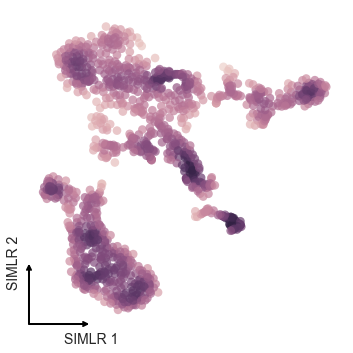

In [ ]:
colon_SIMLR.plot()

In [ ]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=colon.distance_matrix(transform='arcsinh'), post=colon_SIMLR.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh'), post=colon_SIMLR.knn_graph(k))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['SIMLR'], final_distance_stats['Colon']['EMD']['SIMLR'], final_distance_stats['Colon']['Knn Pres.']['SIMLR'] = mantel_stats[0], EMD, knn

R: 0.7662
EMD: 0.0849
Knn Pres.: 96.8255
CPU times: user 24 s, sys: 4.63 s, total: 28.7 s
Wall time: 28.9 s


CPU times: user 10.4 s, sys: 314 ms, total: 10.7 s
Wall time: 10.1 s


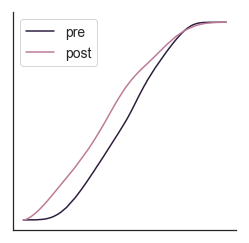

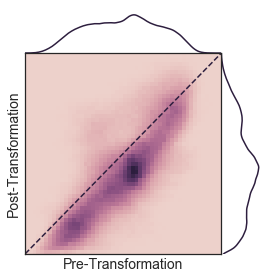

In [ ]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_SIMLR_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_SIMLR_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
### ZINB-WAVE

In [94]:
retina_ZINBWAVE = DR.from_file('Rmethods_out/retina_ZINB-WAVE.csv', name='ZINB-WaVE', labels=[None,0])

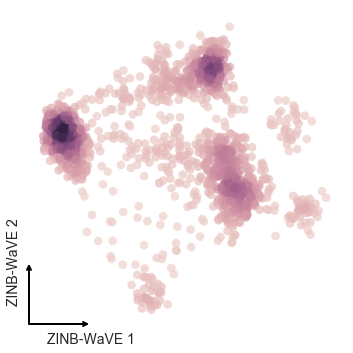

In [95]:
retina_ZINBWAVE.plot()

In [97]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=retina.distance_matrix(transform='arcsinh'), post=retina_ZINBWAVE.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_ZINBWAVE.knn_graph(k))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['ZINB-WaVE'], final_distance_stats['Retina']['EMD']['ZINB-WaVE'], final_distance_stats['Retina']['Knn Pres.']['ZINB-WaVE'] = mantel_stats[0], EMD, knn

R: 0.7916
EMD: 0.273
Knn Pres.: 96.6629
CPU times: user 36.5 s, sys: 6.35 s, total: 42.9 s
Wall time: 43.2 s


CPU times: user 10.7 s, sys: 360 ms, total: 11 s
Wall time: 10.5 s


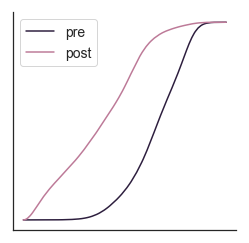

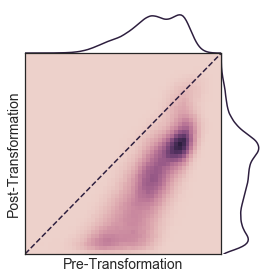

In [98]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_ZINBWAVE_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_ZINBWAVE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

In [99]:
colon_ZINBWAVE = DR.from_file('Rmethods_out/colon_ZINB-WAVE.csv', name='ZINB-WaVE', labels=[None,0])

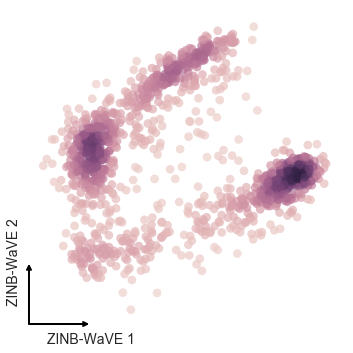

In [100]:
colon_ZINBWAVE.plot()

In [101]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=colon.distance_matrix(transform='arcsinh'), post=colon_ZINBWAVE.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh'), post=colon_ZINBWAVE.knn_graph(k))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['ZINB-WaVE'], final_distance_stats['Colon']['EMD']['ZINB-WaVE'], final_distance_stats['Colon']['Knn Pres.']['ZINB-WaVE'] = mantel_stats[0], EMD, knn

R: 0.9218
EMD: 0.0877
Knn Pres.: 96.7756
CPU times: user 24.1 s, sys: 4.6 s, total: 28.7 s
Wall time: 29.2 s


CPU times: user 10.4 s, sys: 287 ms, total: 10.7 s
Wall time: 10 s


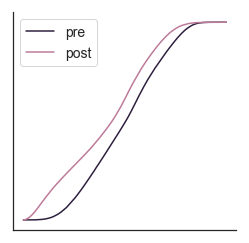

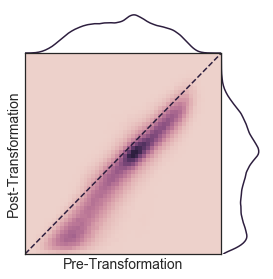

In [102]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_ZINBWAVE_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_ZINBWAVE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
### GLM-PCA

In [103]:
retina_GLMPCA = DR.from_file('Rmethods_out/retina_GLM-PCA.csv', name='GLM-PC', labels=[None,0])

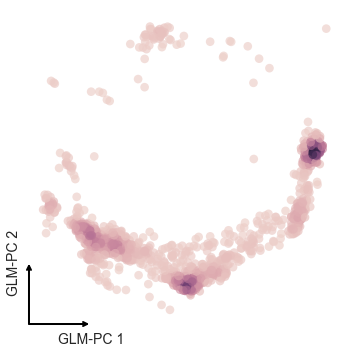

In [104]:
retina_GLMPCA.plot()

In [105]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=retina.distance_matrix(transform='arcsinh'), post=retina_GLMPCA.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_GLMPCA.knn_graph(k))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['GLM-PCA'], final_distance_stats['Retina']['EMD']['GLM-PCA'], final_distance_stats['Retina']['Knn Pres.']['GLM-PCA'] = mantel_stats[0], EMD, knn

R: 0.7918
EMD: 0.2926
Knn Pres.: 96.6734
CPU times: user 36.9 s, sys: 7.24 s, total: 44.2 s
Wall time: 44.7 s


CPU times: user 10.3 s, sys: 298 ms, total: 10.6 s
Wall time: 9.99 s


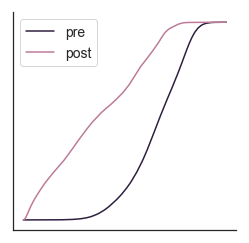

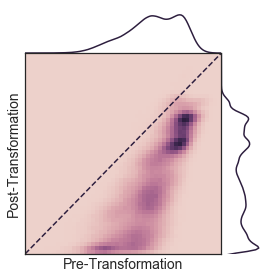

In [106]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_GLMPCA_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_GLMPCA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

In [107]:
colon_GLMPCA = DR.from_file('Rmethods_out/colon_GLM-PCA.csv', name='GLM-PC', labels=[None,0])

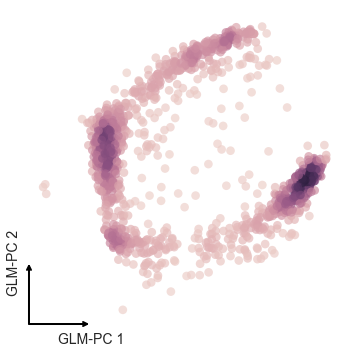

In [108]:
colon_GLMPCA.plot()

In [109]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=colon.distance_matrix(transform='arcsinh'), post=colon_GLMPCA.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh'), post=colon_GLMPCA.knn_graph(k))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['GLM-PCA'], final_distance_stats['Colon']['EMD']['GLM-PCA'], final_distance_stats['Colon']['Knn Pres.']['GLM-PCA'] = mantel_stats[0], EMD, knn

R: 0.9317
EMD: 0.1058
Knn Pres.: 96.9085
CPU times: user 24.3 s, sys: 4.76 s, total: 29.1 s
Wall time: 29.4 s


CPU times: user 10.2 s, sys: 281 ms, total: 10.4 s
Wall time: 9.77 s


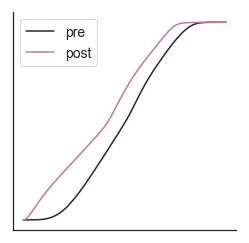

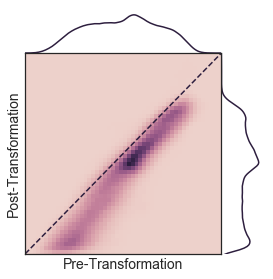

In [110]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_GLMPCA_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_GLMPCA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
### Summary Metrics

In [153]:
retina_sum = pd.DataFrame(final_distance_stats['Retina'])
retina_sum = retina_sum.sort_values(by='R')
retina_sum = retina_sum.reindex(['EMD','R','Knn Pres.'], axis=1)
retina_sum.to_csv('retina_global_metrics.csv')

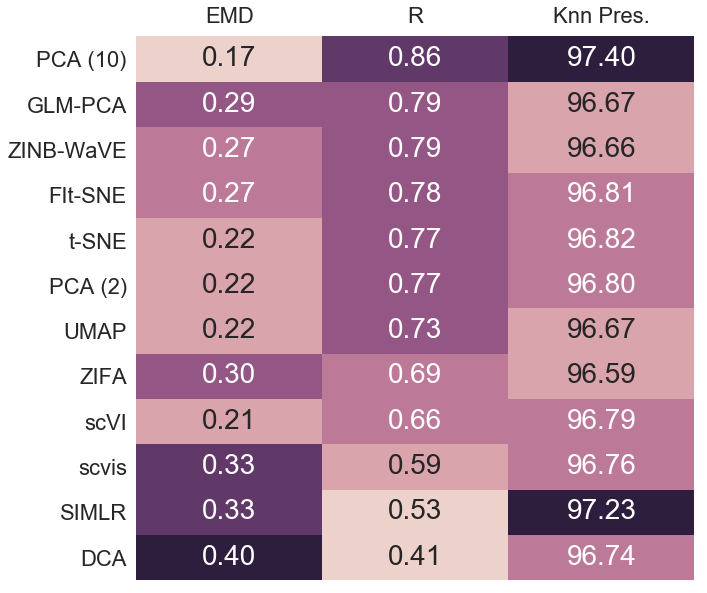

In [154]:
retina_norm=(retina_sum-retina_sum.mean())/retina_sum.std()
sns.set(font_scale=2)
plt.figure(figsize=(10,10))
ax = sns.heatmap(retina_norm, annot=retina_sum, cmap=sns.cubehelix_palette(), robust=True, annot_kws={"size": 28}, fmt='.2f', cbar=False)
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.tick_params(top=False)
plt.savefig(fname='../images/retina_global_metrics.png', transparent=True, bbox_inches='tight')

In [155]:
colon_sum = pd.DataFrame(final_distance_stats['Colon'])
colon_sum = colon_sum.sort_values(by='R')
colon_sum = colon_sum.reindex(['EMD','R','Knn Pres.'], axis=1)
colon_sum.to_csv('colon_global_metrics.csv')

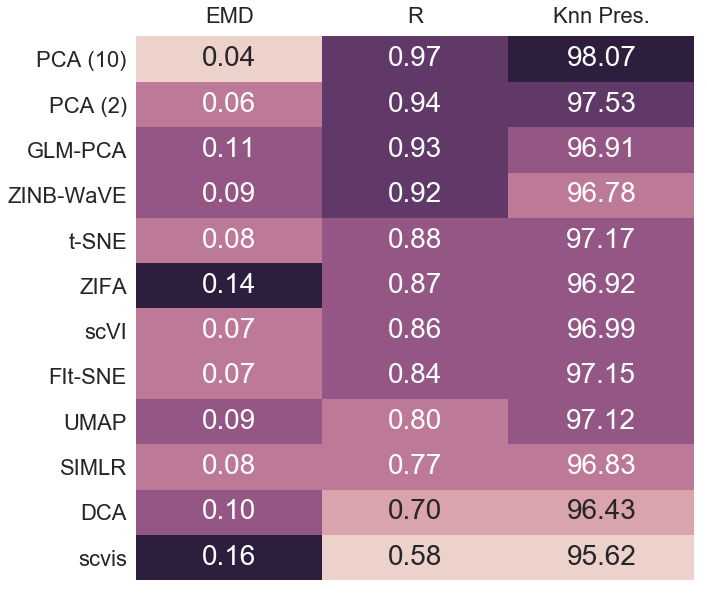

In [156]:
colon_norm=(colon_sum-colon_sum.mean())/colon_sum.std()
sns.set(font_scale=2)
plt.figure(figsize=(10,10))
ax = sns.heatmap(colon_norm, annot=colon_sum, cmap=sns.cubehelix_palette(), robust=True, annot_kws={"size": 28}, fmt='.2f', cbar=False)
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.tick_params(top=False)
plt.savefig(fname='../images/colon_global_metrics.png', transparent=True, bbox_inches='tight')